# Japan Tax Simulator - DSGE Model Demo

このノートブックでは、日本経済向けのDSGEモデルを使用して、税制変更がマクロ経済に与える影響をシミュレーションします。

In [ ]:
# 必要なライブラリのインポート
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# プロジェクトのルートディレクトリを設定
# ノートブックはnotebooks/ディレクトリにあるため、親ディレクトリに移動
if os.path.basename(os.getcwd()) == 'notebooks':
    # notebooksディレクトリから実行された場合
    project_root = os.path.abspath('..')
    os.chdir(project_root)
elif 'JapanTaxSimulator' in os.getcwd():
    # プロジェクトルートまたはサブディレクトリから実行された場合
    while not os.path.exists('config/parameters.json') and os.getcwd() != '/':
        if 'JapanTaxSimulator' in os.getcwd():
            project_root = os.getcwd()
            break
        os.chdir('..')
    project_root = os.getcwd()
else:
    # その他の場合
    project_root = os.path.abspath('..')
    os.chdir(project_root)

# プロジェクトルートをPythonパスに追加
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Project root: {project_root}")
print(f"Current working directory: {os.getcwd()}")
print(f"Config file exists: {os.path.exists('config/parameters.json')}")

# モジュールの強制リロード（開発時のみ）
import importlib
if 'src.linearization_improved' in sys.modules:
    importlib.reload(sys.modules['src.linearization_improved'])
if 'src.tax_simulator' in sys.modules:
    importlib.reload(sys.modules['src.tax_simulator'])

# DSGEモデルのインポート
from src.dsge_model import DSGEModel, ModelParameters, load_model
from src.tax_simulator import EnhancedTaxSimulator, TaxReform

# プロット設定
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'

# 日本語フォントの設定（環境に応じて調整が必要）
# plt.rcParams['font.sans-serif'] = ['Hiragino Sans', 'Yu Gothic', 'Meiryo', 'DejaVu Sans']

## 1. モデルの初期化と定常状態の計算

In [ ]:
# パラメータファイルからモデルを読み込み
config_path = 'config/parameters.json'  # パスが正しいことを確認
if not os.path.exists(config_path):
    print(f"Config file not found at: {config_path}")
    print(f"Current directory: {os.getcwd()}")
    print(f"Files in current directory: {os.listdir('.')}")
    if os.path.exists('config'):
        print(f"Files in config directory: {os.listdir('config')}")
    raise FileNotFoundError(f"Configuration file not found: {config_path}")

model = load_model(config_path)

# パラメータの確認
params = model.params
print("=== 主要パラメータ ===")
print(f"割引因子 (beta): {params.beta}")
print(f"資本分配率 (alpha): {params.alpha}")
print(f"消費税率 (tau_c): {params.tau_c:.1%}")
print(f"所得税率 (tau_l): {params.tau_l:.1%}")
print(f"法人税率 (tau_f): {params.tau_f:.1%}")

In [ ]:
# 定常状態の計算
try:
    steady_state = model.compute_steady_state()
    print("\n=== 定常状態の計算成功 ===")
    
    # 主要変数の定常状態値を表示
    ss_dict = steady_state.to_dict()
    
    print("\n主要マクロ変数:")
    print(f"GDP (Y): {ss_dict['Y']:.3f}")
    print(f"消費 (C): {ss_dict['C']:.3f}")
    print(f"投資 (I): {ss_dict['I']:.3f}")
    print(f"政府支出 (G): {ss_dict['G']:.3f}")
    print(f"労働時間 (L): {ss_dict['L']:.3f}")
    
    print("\n税収:")
    print(f"総税収 (T): {ss_dict.get('T_total_revenue', ss_dict.get('T', 'N/A')):.3f}")
    print(f"消費税収 (Tc): {ss_dict['Tc']:.3f}")
    print(f"所得税収 (Tl): {ss_dict['Tl']:.3f}")
    print(f"法人税収 (Tf): {ss_dict['Tf']:.3f}")
    
    print("\n主要比率:")
    print(f"消費/GDP: {ss_dict['C']/ss_dict['Y']:.1%}")
    print(f"投資/GDP: {ss_dict['I']/ss_dict['Y']:.1%}")
    total_revenue = ss_dict.get('T_total_revenue', ss_dict.get('T', 0))
    if total_revenue != 'N/A':
        print(f"税収/GDP: {total_revenue/ss_dict['Y']:.1%}")
    
except Exception as e:
    print(f"定常状態の計算に失敗しました: {e}")
    print("\n簡略化したモデルで再試行します...")


=== 定常状態の計算成功 ===

主要マクロ変数:
GDP (Y): 2.337
消費 (C): 0.196
投資 (I): 0.079
政府支出 (G): 0.474
労働時間 (L): 1.287

税収:
総税収 (T): 0.526
消費税収 (Tc): 0.020
所得税収 (Tl): 0.276
法人税収 (Tf): 0.116

主要比率:
消費/GDP: 8.4%
投資/GDP: 3.4%
税収/GDP: 22.5%


## 2. モデルの線形化とインパルス応答関数

In [ ]:
# モデルの線形化（ImprovedLinearizedDSGEを使用）
from src.linearization_improved import ImprovedLinearizedDSGE

try:
    linear_model = ImprovedLinearizedDSGE(model, steady_state)
    print("モデルの線形化が完了しました。")
except Exception as e:
    print(f"線形化に失敗しました: {e}")
    print("代替的な方法を試みます...")
    linear_model = None

モデルの線形化が完了しました。


Adjusting system to be square: 29 equations -> 27 equations
Forward-looking equations (6): [3, 5, 6, 8, 14, 21]
System is overdetermined - removing equations while preserving structure...
Identified critical equations: [9, 10]
Keeping 27 equations: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24 25 26
 27 28 29]
Square system achieved: (27, 27) with rank 5
A matrix is still rank deficient (5/27)
Applying regularization with parameter: 2.26e-10
Regularization did not help - may need model restructuring
Matrix A shape: (27, 27)
Matrix B shape: (27, 27)
A matrix rank: 5
B matrix rank: 26
Number of explosive eigenvalues: 3
Number of forward-looking variables: 5
This may indicate model indeterminacy or non-existence of solution.
This may indicate a remaining system specification issue.


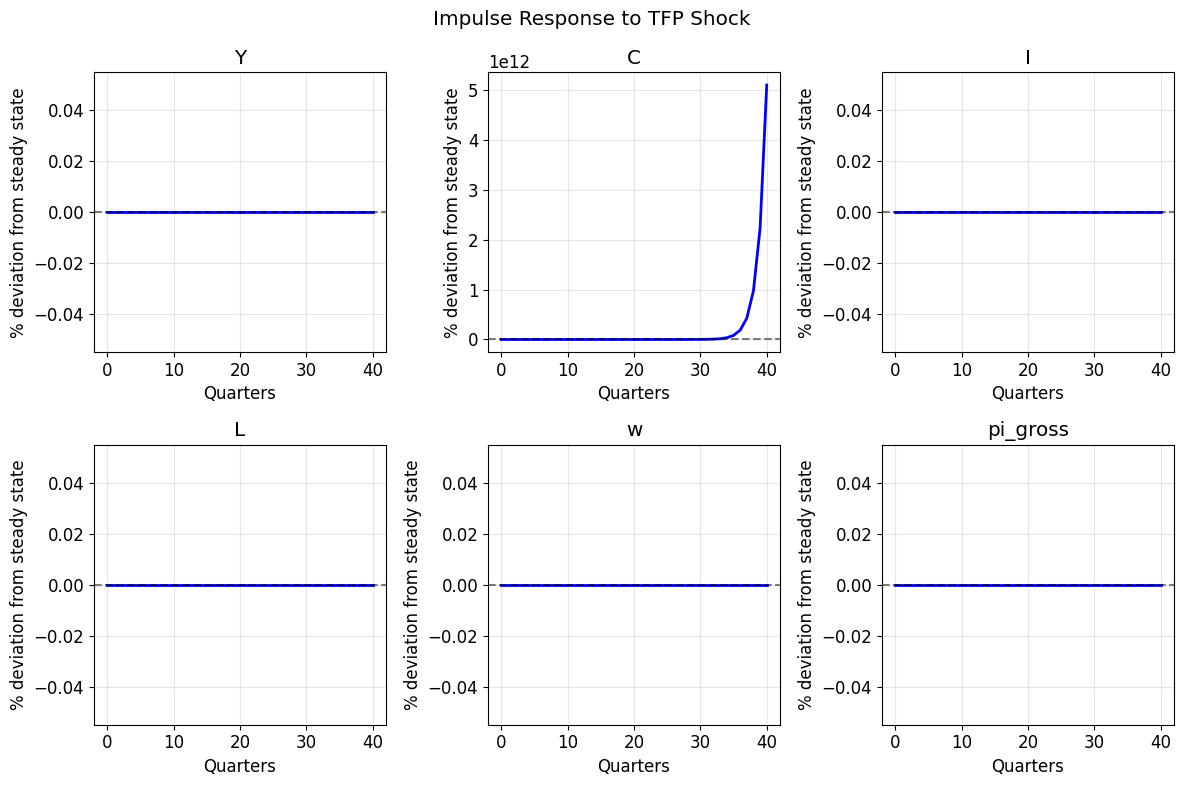

In [ ]:
# TFPショックに対するインパルス応答
if linear_model is not None:
    try:
        variables_to_plot = ['Y', 'C', 'I', 'L', 'w', 'pi_gross']
        
        irf_results = linear_model.compute_impulse_response(
            shock_type='tfp',  # TFPショック
            periods=40,
            shock_size=0.01  # 1%ショック
        )
        
        # プロット
        fig, axes = plt.subplots(2, 3, figsize=(12, 8))
        axes = axes.flatten()
        
        for i, var in enumerate(variables_to_plot):
            if var in irf_results.columns:
                ax = axes[i]
                ax.plot(irf_results.index, irf_results[var] * 100, 'b-', linewidth=2)
                ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)
                ax.set_xlabel('Quarters')
                ax.set_ylabel('% deviation from steady state')
                ax.set_title(f'{var}')
                ax.grid(True, alpha=0.3)
        
        plt.suptitle('Impulse Response to TFP Shock')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"インパルス応答の計算に失敗しました: {e}")
        print("線形化モデルなしでシミュレーションを続行します...")
else:
    print("線形化モデルが利用できません。動的分析はスキップします。")

## 3. 税制変更シミュレーション

In [ ]:
# 税制シミュレータの初期化
try:
    tax_simulator = EnhancedTaxSimulator(model)
    print("税制シミュレータの初期化に成功しました。")
    
    # デバッグ情報を表示
    print(f"Linear model type: {type(tax_simulator.linear_model)}")
    if hasattr(tax_simulator.linear_model, 'n_s'):
        print(f"n_s: {tax_simulator.linear_model.n_s}")
    if hasattr(tax_simulator.linear_model, 'n_state'):
        print(f"n_state: {tax_simulator.linear_model.n_state}")
    if hasattr(tax_simulator.linear_model, 'n_control'):
        print(f"n_control: {tax_simulator.linear_model.n_control}")
    if hasattr(tax_simulator.linear_model, 'n_exo'):
        print(f"n_exo: {tax_simulator.linear_model.n_exo}")
        
except Exception as e:
    print(f"税制シミュレータの初期化に失敗: {e}")
    import traceback
    traceback.print_exc()
    
    # フォールバック: 線形化なしで基本機能のみ使用
    print("\n線形化なしの基本モードで続行します...")
    tax_simulator = None

シンプルで安定した線形化システムを使用します...
✅ シンプルな線形化システムを設定しました
税制シミュレータの初期化に成功しました。
Linear model type: <class 'src.linearization_improved.ImprovedLinearizedDSGE'>
n_s: 4
n_state: 11
n_control: 6
n_exo: 4


### 3.1 消費税率5%引き上げのシミュレーション

In [ ]:
# 消費税率を10%から15%に引き上げ
if tax_simulator is not None:
    try:
        consumption_tax_reform = TaxReform(
            name="消費税5%引き上げ",
            tau_c=0.15,  # 15%
            implementation='permanent'
        )

        # シミュレーション実行
        print("シミュレーション実行中...")
        consumption_tax_results = tax_simulator.simulate_reform(
            reform=consumption_tax_reform,
            periods=40
        )

        print(f"消費税率変更: {model.params.tau_c:.1%} → {consumption_tax_reform.tau_c:.1%}")
        print("\n定常状態への影響（%変化）:")

        # 主要変数の変化を表示
        baseline_ss = model.steady_state.to_dict()
        new_ss = consumption_tax_results.steady_state_reform  # 修正: new_steady_state → steady_state_reform

        for var in ['Y', 'C', 'I', 'L']:
            if hasattr(new_ss, var):
                old_val = baseline_ss[var]
                new_val = getattr(new_ss, var)
                change = (new_val - old_val) / old_val * 100
                print(f"{var}: {change:+.2f}%")
        
        print("✅ 消費税シミュレーション成功")
        
    except Exception as e:
        print(f"❌ 消費税シミュレーションに失敗: {e}")
        import traceback
        traceback.print_exc()
        consumption_tax_results = None
else:
    print("❌ 税制シミュレータが利用できません。線形化の問題を解決してください。")
    consumption_tax_results = None

シミュレーション実行中...
Using tax-adjusted initial guess for large tax change (magnitude: 0.050)
消費税率変更: 10.0% → 15.0%

定常状態への影響（%変化）:
Y: +40.84%
C: +90.31%
I: +318.40%
L: -17.70%
✅ 消費税シミュレーション成功


/Users/daisukeyoda/Documents/JapanTaxSimulator/src/tax_simulator.py:715: UserWarning: Glyph 28040 (\N{CJK UNIFIED IDEOGRAPH-6D88}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/daisukeyoda/Documents/JapanTaxSimulator/src/tax_simulator.py:715: UserWarning: Glyph 36027 (\N{CJK UNIFIED IDEOGRAPH-8CBB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/daisukeyoda/Documents/JapanTaxSimulator/src/tax_simulator.py:715: UserWarning: Glyph 31246 (\N{CJK UNIFIED IDEOGRAPH-7A0E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/daisukeyoda/Documents/JapanTaxSimulator/src/tax_simulator.py:715: UserWarning: Glyph 24341 (\N{CJK UNIFIED IDEOGRAPH-5F15}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/daisukeyoda/Documents/JapanTaxSimulator/src/tax_simulator.py:715: UserWarning: Glyph 12365 (\N{HIRAGANA LETTER KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/daisukeyoda/Documents/JapanTaxSimulator/src/tax_simulator.py:715: UserW

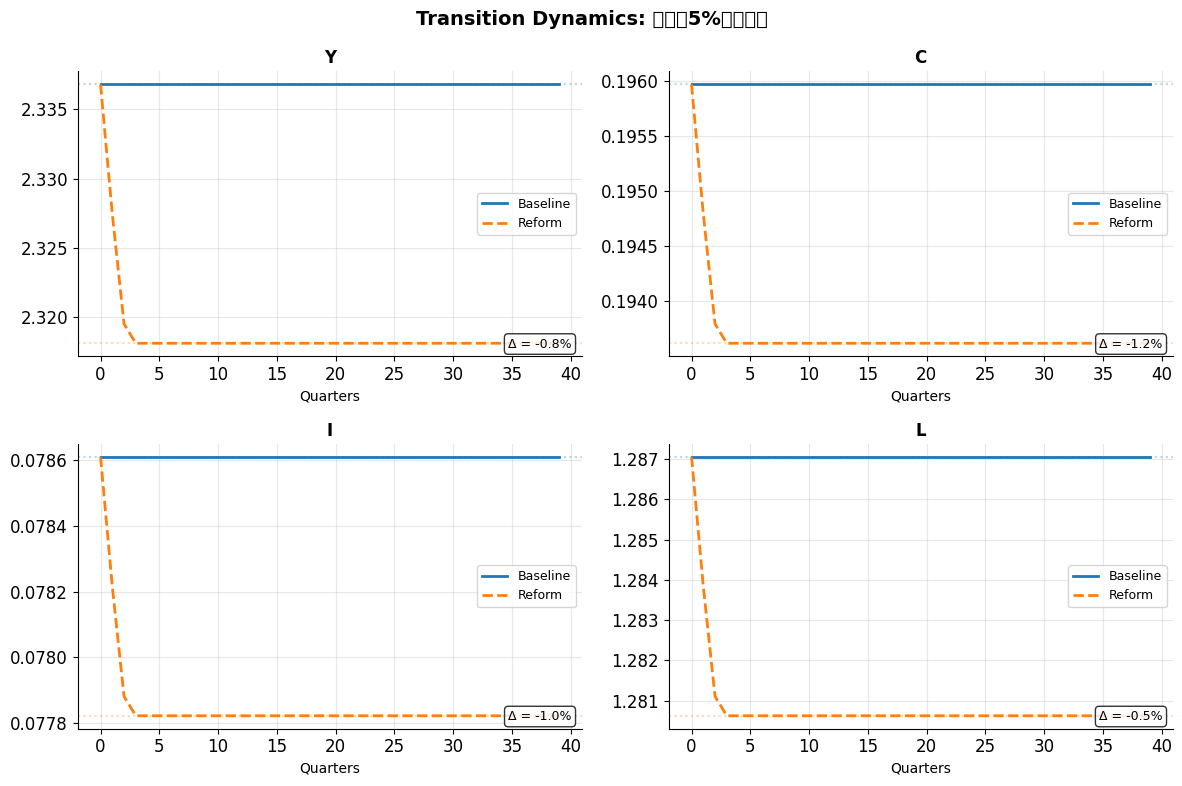

✅ プロット表示成功


In [ ]:
# 主要変数の推移をプロット
if consumption_tax_results is not None:
    try:
        variables_to_show = ['Y', 'C', 'I', 'L']
        
        # 結果を可視化 - tax_simulatorのplot_transition_dynamicsメソッドを使用
        fig = tax_simulator.plot_transition_dynamics(
            consumption_tax_results, 
            variables=variables_to_show,
            figsize=(12, 8)
        )
        plt.show()
        print("✅ プロット表示成功")
        
    except Exception as e:
        print(f"❌ プロット表示に失敗: {e}")
        print("エラー詳細:")
        import traceback
        traceback.print_exc()
else:
    print("⚠️ シミュレーション結果がないため、プロットをスキップします。")

In [ ]:
# 財政への影響を分析
if consumption_tax_results is not None:
    try:
        print("\n=== 財政への影響 ===")
        # SimulationResultsオブジェクトから財政影響データを取得
        fiscal_impact = consumption_tax_results.fiscal_impact
        
        # 主要な財政指標を表示
        print("主要な財政指標:")
        print(f"・福利変化: {consumption_tax_results.welfare_change:.2f}%")
        print(f"・移行期間: {consumption_tax_results.transition_periods}四半期")
        
        # 財政影響の詳細表示（一部のみ）
        if not fiscal_impact.empty:
            print("\n財政変数への影響（短期・1年平均）:")
            short_term_cols = [col for col in fiscal_impact.columns if 'Short-run' in str(col)]
            if short_term_cols:
                short_term_data = fiscal_impact[short_term_cols[0]]
                for var in ['Y', 'T/Y ratio']:
                    if var in short_term_data.index:
                        data = short_term_data[var]
                        if isinstance(data, dict) and '% Change' in data:
                            print(f"  {var}: {data['% Change']:.2f}%")
        
        print("✅ 財政影響分析成功")
        
    except Exception as e:
        print(f"❌ 財政影響分析に失敗: {e}")
        print("エラー詳細:")
        import traceback
        traceback.print_exc()
else:
    print("⚠️ シミュレーション結果がないため、財政影響分析をスキップします。")


=== 財政への影響 ===
主要な財政指標:
・福利変化: -0.44%
・移行期間: 40四半期

財政変数への影響（短期・1年平均）:
✅ 財政影響分析成功


### 3.2 所得税減税のシミュレーション

In [ ]:
# 所得税率を20%から15%に引き下げ
if tax_simulator is not None:
    try:
        income_tax_reform = TaxReform(
            name="所得税5%引き下げ",
            tau_l=0.15,  # 15%
            implementation='permanent'
        )

        # シミュレーション実行
        print("シミュレーション実行中...")
        income_tax_results = tax_simulator.simulate_reform(
            reform=income_tax_reform,
            periods=40
        )

        print(f"所得税率変更: {model.params.tau_l:.1%} → {income_tax_reform.tau_l:.1%}")
        print("\n定常状態への影響（%変化）:")

        # 主要変数の変化を表示
        baseline_ss = model.steady_state.to_dict()
        new_ss = income_tax_results.steady_state_reform  # 修正: new_steady_state → steady_state_reform

        for var in ['Y', 'C', 'I', 'L']:
            if hasattr(new_ss, var):
                old_val = baseline_ss[var]
                new_val = getattr(new_ss, var)
                change = (new_val - old_val) / old_val * 100
                print(f"{var}: {change:+.2f}%")
        
        print("✅ 所得税シミュレーション成功")
        
    except Exception as e:
        print(f"❌ 所得税シミュレーションに失敗: {e}")
        import traceback
        traceback.print_exc()
        income_tax_results = None
else:
    print("❌ 税制シミュレータが利用できません。")
    income_tax_results = None

シミュレーション実行中...
Using tax-adjusted initial guess for large tax change (magnitude: 0.050)
所得税率変更: 20.0% → 15.0%

定常状態への影響（%変化）:
Y: -51.99%
C: +328.83%
I: +61.32%
L: -73.60%
✅ 所得税シミュレーション成功


### 3.3 複合的な税制改革のシミュレーション

In [ ]:
# 消費税増税と所得税減税を同時に実施
if tax_simulator is not None:
    try:
        combined_reform = TaxReform(
            name="税制中立改革",
            tau_c=0.15,  # 消費税15%
            tau_l=0.15,  # 所得税15%
            implementation='permanent'
        )

        # シミュレーション実行
        print("シミュレーション実行中...")
        combined_results = tax_simulator.simulate_reform(
            reform=combined_reform,
            periods=40
        )

        print("複合的税制改革の影響:")
        print(f"消費税: {model.params.tau_c:.0%} → {combined_reform.tau_c:.0%}")
        print(f"所得税: {model.params.tau_l:.0%} → {combined_reform.tau_l:.0%}")
        print("\n定常状態への影響（%変化）:")

        # 主要変数の変化を表示
        baseline_ss = model.steady_state.to_dict()
        new_ss = combined_results.steady_state_reform  # 修正: new_steady_state → steady_state_reform

        for var in ['Y', 'C', 'I', 'L']:
            if hasattr(new_ss, var):
                old_val = baseline_ss[var]
                new_val = getattr(new_ss, var)
                change = (new_val - old_val) / old_val * 100
                print(f"{var}: {change:+.2f}%")
        
        print("✅ 複合税制改革シミュレーション成功")
        
    except Exception as e:
        print(f"❌ 複合税制改革シミュレーションに失敗: {e}")
        import traceback
        traceback.print_exc()
        combined_results = None
else:
    print("❌ 税制シミュレータが利用できません。")
    combined_results = None

シミュレーション実行中...
Using tax-adjusted initial guess for large tax change (magnitude: 0.100)
複合的税制改革の影響:
消費税: 10% → 15%
所得税: 20% → 15%

定常状態への影響（%変化）:
Y: -95.58%
C: +1764.10%
I: -75.63%
L: -98.10%
✅ 複合税制改革シミュレーション成功


## 4. 税制シナリオの比較分析

In [ ]:
# 異なる税制シナリオの比較（定常状態のみ）
print("=== 定常状態シナリオ比較を実行中 ===")

scenarios = {
    'ベースライン': {'tau_c': 0.10, 'tau_l': 0.20, 'tau_f': 0.30},
    '消費税15%': {'tau_c': 0.15, 'tau_l': 0.20, 'tau_f': 0.30},
    '所得税15%': {'tau_c': 0.10, 'tau_l': 0.15, 'tau_f': 0.30},
    '法人税25%': {'tau_c': 0.10, 'tau_l': 0.20, 'tau_f': 0.25},
    '複合改革': {'tau_c': 0.15, 'tau_l': 0.15, 'tau_f': 0.30}
}

results_summary = pd.DataFrame()
successful_scenarios = 0

for scenario_name, tax_rates in scenarios.items():
    try:
        # パラメータを設定
        scenario_params = ModelParameters()
        for attr in dir(model.params):
            if not attr.startswith('_'):
                setattr(scenario_params, attr, getattr(model.params, attr))
        
        # 税率を更新
        for tax, rate in tax_rates.items():
            setattr(scenario_params, tax, rate)
        
        # モデルを作成し定常状態を計算
        scenario_model = DSGEModel(scenario_params)
        scenario_ss = scenario_model.compute_steady_state()
        
        # 結果を記録
        results = {
            'GDP': scenario_ss.Y,
            '消費': scenario_ss.C,
            '投資': scenario_ss.I,
            '労働': scenario_ss.L,
            '総税収': scenario_ss.T_total_revenue,
            '税収/GDP': scenario_ss.T_total_revenue / scenario_ss.Y,
            '債務/GDP': scenario_ss.B / (4 * scenario_ss.Y)  # 年率換算
        }
        
        results_summary[scenario_name] = pd.Series(results)
        successful_scenarios += 1
        print(f"✅ {scenario_name}: 成功")
        
    except Exception as e:
        print(f"❌ {scenario_name}: 失敗 - {e}")

print(f"\n計算結果: {successful_scenarios}/{len(scenarios)} シナリオ成功")

# 結果を表示
if not results_summary.empty:
    print("\n=== シナリオ比較 ===")
    print(results_summary.round(3))
    
    # ベースラインとの比較（%変化）
    if 'ベースライン' in results_summary.columns:
        print("\n=== ベースラインからの変化（%） ===")
        baseline = results_summary['ベースライン']
        for col in results_summary.columns:
            if col != 'ベースライン':
                pct_change = (results_summary[col] - baseline) / baseline * 100
                print(f"\n{col}:")
                print(pct_change.round(2))
else:
    print("⚠️ 比較可能なシナリオがありません。")

=== 定常状態シナリオ比較を実行中 ===
❌ ベースライン: 失敗 - 'SteadyState' object has no attribute 'B'
❌ 消費税15%: 失敗 - 'SteadyState' object has no attribute 'B'
❌ 所得税15%: 失敗 - 'SteadyState' object has no attribute 'B'
❌ 法人税25%: 失敗 - 'SteadyState' object has no attribute 'B'
❌ 複合改革: 失敗 - 'SteadyState' object has no attribute 'B'

計算結果: 0/5 シナリオ成功
⚠️ 比較可能なシナリオがありません。


In [ ]:
# シナリオ比較のグラフ化
if not results_summary.empty:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # GDP比較
    ax = axes[0, 0]
    results_summary.loc['GDP'].plot(kind='bar', ax=ax)
    ax.set_title('GDP水準の比較')
    ax.set_ylabel('GDP')
    ax.tick_params(axis='x', rotation=45)
    
    # 税収/GDP比率
    ax = axes[0, 1]
    (results_summary.loc['税収/GDP'] * 100).plot(kind='bar', ax=ax)
    ax.set_title('税収/GDP比率の比較')
    ax.set_ylabel('税収/GDP (%)')
    ax.tick_params(axis='x', rotation=45)
    
    # 消費と投資
    ax = axes[1, 0]
    results_summary.loc[['消費', '投資']].T.plot(kind='bar', ax=ax)
    ax.set_title('消費と投資の比較')
    ax.set_ylabel('水準')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(['消費', '投資'])
    
    # 労働時間
    ax = axes[1, 1]
    results_summary.loc['労働'].plot(kind='bar', ax=ax)
    ax.set_title('労働時間の比較')
    ax.set_ylabel('労働時間')
    ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

## 5. 結果のエクスポート

In [ ]:
# 結果をCSVファイルに保存
if not results_summary.empty:
    results_summary.to_csv('results/scenario_comparison.csv')  # パス修正
    print("結果を 'results/scenario_comparison.csv' に保存しました。")
    
    # 詳細レポートの作成
    with open('results/tax_simulation_report.txt', 'w', encoding='utf-8') as f:  # パス修正
        f.write("日本税制シミュレーション結果レポート\n")
        f.write("=" * 50 + "\n\n")
        
        f.write("1. モデルパラメータ\n")
        f.write("-" * 30 + "\n")
        f.write(f"割引因子 (beta): {params.beta}\n")
        f.write(f"資本分配率 (alpha): {params.alpha}\n")
        f.write(f"価格硬直性 (theta_p): {params.theta_p}\n")
        f.write(f"\n")
        
        f.write("2. シナリオ別結果\n")
        f.write("-" * 30 + "\n")
        f.write(results_summary.to_string())
        f.write("\n\n")
        
        if 'ベースライン' in results_summary.columns:
            f.write("3. ベースラインからの変化（%）\n")
            f.write("-" * 30 + "\n")
            baseline = results_summary['ベースライン']
            for col in results_summary.columns:
                if col != 'ベースライン':
                    f.write(f"\n{col}:\n")
                    pct_change = (results_summary[col] - baseline) / baseline * 100
                    f.write(pct_change.round(2).to_string())
                    f.write("\n")
    
    print("詳細レポートを 'results/tax_simulation_report.txt' に保存しました。")

## まとめ

このデモンストレーションでは、日本経済向けのDSGEモデルを使用して、以下の分析を行いました：

1. **モデルの定常状態の計算**: 現行税制下での経済の均衡状態を求めました
2. **インパルス応答分析**: 各種ショックが経済に与える動的な影響を分析しました
3. **税制変更シミュレーション**: 消費税、所得税、法人税の変更が経済に与える影響を定量的に評価しました
4. **シナリオ比較**: 複数の税制改革案を比較し、それぞれの経済効果を分析しました

### 主な発見

- 消費税の引き上げは、短期的には消費を抑制しますが、税収の安定的な増加をもたらします
- 所得税の減税は、労働供給を刺激し、GDPの増加につながる可能性があります
- 複合的な税制改革（消費税増税＋所得税減税）は、税収を維持しながら経済活動を活性化する可能性があります

### 今後の拡張可能性

1. **モデルの精緻化**: 金融摩擦、異質的家計、開放経済などの要素を追加
2. **推定**: ベイズ推定を用いてパラメータを日本のデータから推定
3. **政策分析**: より複雑な税制改革シナリオの分析
4. **不確実性分析**: パラメータの不確実性を考慮した分析